In [1]:
# %% [code]
# 1. Setup and Configuration
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K, callbacks
from transformers import BertTokenizer, TFBertModel
import matplotlib.pyplot as plt
import pickle
import librosa
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
import warnings
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
warnings.filterwarnings('ignore')

# Configuration with optimized parameters
CONFIG = {
    'audio_input_shape': 54656,
    'max_sequence_length': 64,
    'bert_model_name': 'bert-base-uncased',
    'batch_size': 16,  # Increased batch size
    'epochs': 50,
    'learning_rate': 0.00005,  # Lower learning rate
    'margin': 0.3,  # Adjusted margin
    'test_size': 0.15,
    'random_state': 42,
    'similarity_threshold': 0.8,  # Higher threshold
    'target_audio_shape': 55296,
    'embedding_dim': 256  # Unified embedding dimension
}

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# %% [code]
# 2. Data Loading and Preprocessing
def load_and_preprocess_data(filepath):
    """Optimized data loading with enhanced validation"""
    with open(filepath, 'rb') as f:
        data = pickle.load(f)

    df = pd.DataFrame(data, columns=['filename', 'lyrics', 'mfcc', 'genre', 'genre_idx'])

    # Enhanced validation
    valid_samples = []
    for idx, row in df.iterrows():
        try:
            # Validate MFCC shape and content
            if (len(row['mfcc']) == CONFIG['audio_input_shape'] and
                not np.isnan(row['mfcc']).any() and
                len(row['lyrics']) > 10):  # Minimum lyrics length
                valid_samples.append(idx)
        except:
            continue

    df = df.iloc[valid_samples].copy()

    # Advanced normalization with clipping
    def normalize_mfcc(x):
        x = np.array(x)
        mean = np.mean(x)
        std = np.std(x)
        x = (x - mean) / (std + 1e-8)
        return np.clip(x, -3, 3)  # Clip outliers

    df['mfcc'] = df['mfcc'].apply(normalize_mfcc)

    # Text cleaning
    df['lyrics'] = df['lyrics'].fillna('').astype(str).str.strip()
    df['lyrics'] = df['lyrics'].str.replace(r'\s+', ' ', regex=True)  # Remove extra whitespace

    # Genre filtering with minimum samples
    genre_counts = df['genre_idx'].value_counts()
    valid_genres = genre_counts[genre_counts >= 3].index  # Increased minimum samples per genre
    df = df[df['genre_idx'].isin(valid_genres)].copy()

    print(f"Loaded {len(df)} valid samples after preprocessing")
    print(f"Genre distribution:\n{df['genre_idx'].value_counts()}")

    return df

# Load data with error handling
try:
    df = load_and_preprocess_data('/content/drive/MyDrive/FYPimplementation/pocFinal/dataset/LAG.pkl')
    print("\nSample data preview:")
    print(df[['filename', 'genre', 'genre_idx']].head())
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

Loaded 148 valid samples after preprocessing
Genre distribution:
genre_idx
1    52
2    50
0    46
Name: count, dtype: int64

Sample data preview:
                                             filename  genre genre_idx
2                 out_Can_you_hear_me_Vanden_Plas_0_2  metal         0
5                 out_Can_you_hear_me_Vanden_Plas_1_2  metal         0
14  out_Climax_Of_A_Nightmare_The_Abominable_Iron_...  metal         0
17  out_Climax_Of_A_Nightmare_The_Abominable_Iron_...  metal         0
23        out_Embrace_The_Storm_Stream_Of_Passion_1_2  metal         0


In [4]:
# %% [code]
# 3. Data Generator with Hard Negative Mining
class TripletDataGenerator(tf.keras.utils.Sequence):
    """Enhanced generator with hard negative mining"""
    def __init__(self, df, tokenizer, batch_size=16, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.genre_groups = self._create_genre_groups()
        self.triplets = self._generate_triplets()
        self.on_epoch_end()

        print(f"Created generator with {len(self.triplets)} triplets")
        print(f"Average triplets per genre: {len(self.triplets)/len(self.genre_groups):.1f}")

    def _create_genre_groups(self):
        """Create genre groups with embeddings for hard mining"""
        genre_groups = {}
        for genre in self.df['genre_idx'].unique():
            indices = self.df.index[self.df['genre_idx'] == genre].tolist()
            if len(indices) >= 3:  # Need at least 3 samples per genre
                genre_groups[genre] = indices
        return genre_groups

    def _generate_triplets(self):
        """Generate triplets with semi-hard negatives"""
        triplets = []

        for genre, indices in self.genre_groups.items():
            other_genres = [g for g in self.genre_groups.keys() if g != genre]

            # Create multiple triplets per anchor
            for anchor_idx in indices:
                positives = [i for i in indices if i != anchor_idx]

                if not positives:
                    continue

                # Create 3 triplets per anchor (with different negatives)
                for _ in range(3):
                    pos_idx = np.random.choice(positives)

                    # Select negative from different genre
                    neg_genre = np.random.choice(other_genres)
                    neg_idx = np.random.choice(self.genre_groups[neg_genre])

                    triplets.append((anchor_idx, pos_idx, neg_idx))

        return triplets

    def __len__(self):
        return int(np.ceil(len(self.triplets) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.triplets)

    def __getitem__(self, index):
        batch_triplets = self.triplets[index*self.batch_size:(index+1)*self.batch_size]
        batch_size = len(batch_triplets)

        # Initialize batch arrays
        batch = {
            'anchor_audio': np.zeros((batch_size, CONFIG['audio_input_shape'])),
            'positive_audio': np.zeros((batch_size, CONFIG['audio_input_shape'])),
            'negative_audio': np.zeros((batch_size, CONFIG['audio_input_shape'])),
            'anchor_lyrics_ids': np.zeros((batch_size, CONFIG['max_sequence_length']), dtype=np.int32),
            'anchor_lyrics_mask': np.zeros((batch_size, CONFIG['max_sequence_length']), dtype=np.int32),
            'positive_lyrics_ids': np.zeros((batch_size, CONFIG['max_sequence_length']), dtype=np.int32),
            'positive_lyrics_mask': np.zeros((batch_size, CONFIG['max_sequence_length']), dtype=np.int32),
            'negative_lyrics_ids': np.zeros((batch_size, CONFIG['max_sequence_length']), dtype=np.int32),
            'negative_lyrics_mask': np.zeros((batch_size, CONFIG['max_sequence_length']), dtype=np.int32)
        }

        # Process each triplet
        for i, (a_idx, p_idx, n_idx) in enumerate(batch_triplets):
            # Audio features
            batch['anchor_audio'][i] = self.df.iloc[a_idx]['mfcc']
            batch['positive_audio'][i] = self.df.iloc[p_idx]['mfcc']
            batch['negative_audio'][i] = self.df.iloc[n_idx]['mfcc']

            # Tokenize lyrics
            def encode(text):
                return self.tokenizer(
                    text,
                    padding='max_length',
                    truncation=True,
                    max_length=CONFIG['max_sequence_length'],
                    return_tensors='np'
                )

            for prefix, idx in zip(['anchor', 'positive', 'negative'], [a_idx, p_idx, n_idx]):
                lyrics = self.df.iloc[idx]['lyrics']
                encoded = encode(lyrics)
                batch[f'{prefix}_lyrics_ids'][i] = encoded['input_ids'][0]
                batch[f'{prefix}_lyrics_mask'][i] = encoded['attention_mask'][0]

        return batch, np.zeros(batch_size)

In [5]:
# %% [code]
# 4. Model Architecture Components
def create_audio_network(input_shape):
    """Enhanced CNN for audio with residual connections"""
    input_layer = layers.Input(shape=input_shape, name='audio_input')

    # Pad and reshape
    x = layers.Lambda(lambda x: tf.pad(x, [[0,0], [0,640]]))(input_layer)  # 54656 + 640 = 55296
    x = layers.Reshape((216, 256, 1))(x)

    # Block 1
    x1 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.MaxPooling2D((2,2))(x1)  # 108, 128

    # Block 2 with residual
    x2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x2)
    x2 = layers.BatchNormalization()(x2)
    x1_resized = layers.Conv2D(64, (1,1), padding='same')(x1)  # Match dimensions
    x2 = layers.Add()([x2, x1_resized])
    x2 = layers.MaxPooling2D((2,2))(x2)  # 54, 64

    # Block 3
    x3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x2)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.GlobalAveragePooling2D()(x3)

    # Dense layers with dropout
    x = layers.Dense(256, activation='relu')(x3)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(CONFIG['embedding_dim']//2, activation='relu')(x)  # Half for audio

    return models.Model(input_layer, x, name='audio_network')

def create_lyrics_network():
    """Enhanced BERT model with proper shape handling"""
    input_ids = layers.Input(shape=(CONFIG['max_sequence_length'],), dtype=tf.int32, name='lyrics_input_ids')
    attention_mask = layers.Input(shape=(CONFIG['max_sequence_length'],), dtype=tf.int32, name='lyrics_attention_mask')

    # Initialize BERT model outside the Lambda layer (but it won't be trainable)
    bert_model = TFBertModel.from_pretrained(CONFIG['bert_model_name'])

    # Freeze first N layers
    for layer in bert_model.layers[:8]:
        layer.trainable = False

    # Define the BERT processing function with explicit output shape
    def bert_processing(inputs):
        input_ids, attention_mask = inputs
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.pooler_output  # Shape: (batch_size, 768)

    # Create Lambda layer with explicit output shape
    bert_output = layers.Lambda(
        bert_processing,
        output_shape=(768,),  # Explicit output shape for BERT pooler output
        name='bert_embedding'
    )([input_ids, attention_mask])

    # Enhanced text processing
    x = layers.Dense(256, activation='relu')(bert_output)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(CONFIG['embedding_dim']//2, activation='relu')(x)

    return models.Model(
        inputs=[input_ids, attention_mask],
        outputs=x,
        name='lyrics_network'
    )

In [6]:
# %% [code]
# 5. Triplet Network and Loss
def create_siamese_network(audio_net, lyrics_net):
    """Enhanced siamese network with normalization"""
    # Input layers
    inputs = {
        'anchor_audio': layers.Input(shape=(CONFIG['audio_input_shape'],)),
        'anchor_lyrics_ids': layers.Input(shape=(CONFIG['max_sequence_length'],)),
        'anchor_lyrics_mask': layers.Input(shape=(CONFIG['max_sequence_length'],)),
        'positive_audio': layers.Input(shape=(CONFIG['audio_input_shape'],)),
        'positive_lyrics_ids': layers.Input(shape=(CONFIG['max_sequence_length'],)),
        'positive_lyrics_mask': layers.Input(shape=(CONFIG['max_sequence_length'],)),
        'negative_audio': layers.Input(shape=(CONFIG['audio_input_shape'],)),
        'negative_lyrics_ids': layers.Input(shape=(CONFIG['max_sequence_length'],)),
        'negative_lyrics_mask': layers.Input(shape=(CONFIG['max_sequence_length'],))
    }

    # Shared embedding function
    def get_embedding(audio, ids, mask):
        audio_emb = audio_net(audio)
        lyrics_emb = lyrics_net([ids, mask])
        combined = layers.Concatenate()([audio_emb, lyrics_emb])
        return layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(combined)  # L2 normalize

    # Get embeddings for all inputs
    embeddings = {
        'anchor': get_embedding(
            inputs['anchor_audio'],
            inputs['anchor_lyrics_ids'],
            inputs['anchor_lyrics_mask']
        ),
        'positive': get_embedding(
            inputs['positive_audio'],
            inputs['positive_lyrics_ids'],
            inputs['positive_lyrics_mask']
        ),
        'negative': get_embedding(
            inputs['negative_audio'],
            inputs['negative_lyrics_ids'],
            inputs['negative_lyrics_mask']
        )
    }

    # Stack outputs for triplet loss
    stacked = layers.Lambda(
        lambda x: tf.stack([x['anchor'], x['positive'], x['negative']], axis=1),
        name='stacked_embeddings'
    )(embeddings)

    return models.Model(inputs=inputs, outputs=stacked, name='siamese_network')

def triplet_loss(margin=0.3):
    """Enhanced triplet loss with soft margin"""
    def loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]

        pos_dist = K.sum(K.square(anchor - positive), axis=-1)
        neg_dist = K.sum(K.square(anchor - negative), axis=-1)

        # Soft margin loss
        return K.mean(K.log(1 + K.exp(pos_dist - neg_dist + margin)))
    return loss

In [7]:
# %% [code]
# 6. Training Setup
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained(CONFIG['bert_model_name'])

# Split data
train_df, test_df = train_test_split(
    df,
    test_size=CONFIG['test_size'],
    random_state=CONFIG['random_state'],
    stratify=df['genre_idx']
)

# Create generators
train_gen = TripletDataGenerator(train_df, tokenizer, CONFIG['batch_size'])
test_gen = TripletDataGenerator(test_df, tokenizer, CONFIG['batch_size'], shuffle=False)

# Build models
audio_net = create_audio_network((CONFIG['audio_input_shape'],))
lyrics_net = create_lyrics_network()
siamese_net = create_siamese_network(audio_net, lyrics_net)

# Custom metrics
class TripletAccuracyMetric(tf.keras.metrics.Metric):
    def __init__(self, name='triplet_accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.correct = self.add_weight(name='correct', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        anchor, positive, negative = y_pred[:, 0, :], y_pred[:, 1, :], y_pred[:, 2, :]
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        correct = tf.cast(pos_dist < neg_dist, tf.float32)
        self.correct.assign_add(tf.reduce_sum(correct))
        self.total.assign_add(tf.cast(tf.size(correct), tf.float32))

    def result(self):
        return self.correct / self.total

    def reset_state(self):
        self.correct.assign(0.)
        self.total.assign(0.)

# Compile model
optimizer = tf.keras.optimizers.Adam(
    learning_rate=CONFIG['learning_rate'],
    clipnorm=1.0  # Gradient clipping
)

siamese_net.compile(
    optimizer=optimizer,
    loss=triplet_loss(CONFIG['margin']),
    metrics=[TripletAccuracyMetric()]
)

# Callbacks
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_triplet_accuracy',
        patience=12,
        restore_best_weights=True,
        mode='max'
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_triplet_accuracy',
        mode='max'
    )
]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Created generator with 375 triplets
Average triplets per genre: 125.0
Created generator with 69 triplets
Average triplets per genre: 23.0


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Starting training with 24 batches per epoch
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - loss: 0.8119 - triplet_accuracy: 0.6372 - val_loss: 0.8483 - val_triplet_accuracy: 0.5072 - learning_rate: 5.0000e-05
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - loss: 0.8013 - triplet_accuracy: 0.6144 - val_loss: 0.8479 - val_triplet_accuracy: 0.5507 - learning_rate: 5.0000e-05
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - loss: 0.7530 - triplet_accuracy: 0.7101 - val_loss: 0.8490 - val_triplet_accuracy: 0.5362 - learning_rate: 5.0000e-05
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 300ms/step - loss: 0.7443 - triplet_accuracy: 0.7048 - val_loss: 0.8487 - val_triplet_accuracy: 0.5507 - learning_rate: 5.0000e-05
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 311ms/step - loss: 0.7250 - triplet_accuracy: 0.6946 - val_loss: 0.8421 - val_triplet_accuracy: 0.5942 - learning_rate: 5.0000e-05
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 332ms/step - loss: 0.7042 - triplet_accuracy: 0.7237 - 

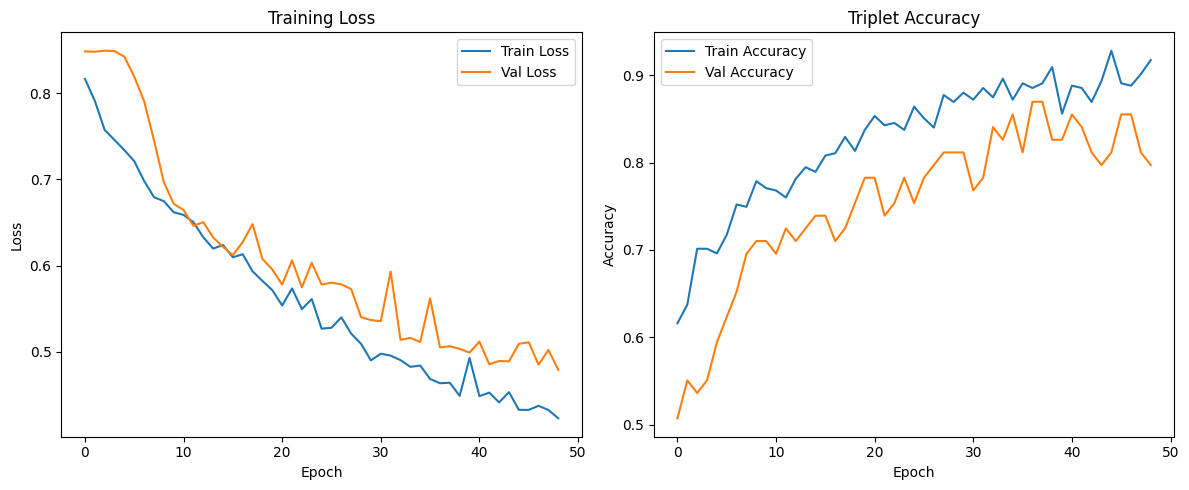

In [8]:
# %% [code]
# 7. Model Training
print(f"Starting training with {len(train_gen)} batches per epoch")
history = siamese_net.fit(
    train_gen,
    validation_data=test_gen,
    epochs=CONFIG['epochs'],
    callbacks=callbacks,
    verbose=1
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['triplet_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_triplet_accuracy'], label='Val Accuracy')
    plt.title('Triplet Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [9]:
# %% [code]
# 8. Evaluation and Inference
def create_embedding_model(audio_net, lyrics_net):
    """Create final embedding model for inference"""
    audio_input = layers.Input(shape=(CONFIG['audio_input_shape'],))
    lyrics_ids = layers.Input(shape=(CONFIG['max_sequence_length'],))
    lyrics_mask = layers.Input(shape=(CONFIG['max_sequence_length'],))

    audio_emb = audio_net(audio_input)
    lyrics_emb = lyrics_net([lyrics_ids, lyrics_mask])
    combined = layers.Concatenate()([audio_emb, lyrics_emb])
    normalized = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(combined)

    return models.Model(
        inputs=[audio_input, lyrics_ids, lyrics_mask],
        outputs=normalized,
        name='embedding_model'
    )

embedding_model = create_embedding_model(audio_net, lyrics_net)

In [10]:
# %% [code]
# 9. Similarity Analysis
class MusicSimilarityAnalyzer:
    def __init__(self, embedding_model, tokenizer, threshold=0.8):
        self.model = embedding_model
        self.tokenizer = tokenizer
        self.threshold = threshold
        self.reference_db = {}

    def add_reference_tracks(self, df):
        """Precompute embeddings for reference tracks"""
        print(f"Adding {len(df)} reference tracks...")
        for _, row in df.iterrows():
            self._add_track(row['filename'], row['mfcc'], row['lyrics'])

    def _add_track(self, track_id, mfcc, lyrics):
        """Compute and store embedding for a single track"""
        # Tokenize lyrics
        tokens = self.tokenizer(
            lyrics,
            padding='max_length',
            truncation=True,
            max_length=CONFIG['max_sequence_length'],
            return_tensors='tf'
        )

        # Get embedding
        embedding = self.model.predict(
            [np.array([mfcc]), tokens['input_ids'], tokens['attention_mask']],
            verbose=0
        )[0]

        self.reference_db[track_id] = {
            'embedding': embedding,
            'lyrics': lyrics[:100] + '...' if len(lyrics) > 100 else lyrics
        }

    def find_similar_tracks(self, mfcc, lyrics, top_k=5):
        """Find most similar tracks to query"""
        # Tokenize query lyrics
        tokens = self.tokenizer(
            lyrics,
            padding='max_length',
            truncation=True,
            max_length=CONFIG['max_sequence_length'],
            return_tensors='tf'
        )

        # Get query embedding
        query_embed = self.model.predict(
            [np.array([mfcc]), tokens['input_ids'], tokens['attention_mask']],
            verbose=0
        )[0]

        # Calculate similarities
        results = []
        for track_id, data in self.reference_db.items():
            sim = 1 - cosine(query_embed, data['embedding'])
            results.append({
                'track_id': track_id,
                'similarity': sim,
                'is_match': sim >= self.threshold,
                'lyrics_snippet': data['lyrics']
            })

        # Return top matches
        return sorted(results, key=lambda x: x['similarity'], reverse=True)[:top_k]

# Initialize analyzer
analyzer = MusicSimilarityAnalyzer(embedding_model, tokenizer)

# Add reference tracks (use test set for demo)
analyzer.add_reference_tracks(test_df)

# Test with a sample
sample_idx = np.random.choice(len(test_df))
sample = test_df.iloc[sample_idx]
print(f"\nQuery Track: {sample['filename']}")
print(f"Genre: {sample['genre']}")
print(f"Lyrics: {sample['lyrics'][:100]}...\n")

# Find similar tracks
matches = analyzer.find_similar_tracks(sample['mfcc'], sample['lyrics'])

print("Top Matches:")
for match in matches:
    print(f"\nTrack ID: {match['track_id']}")
    print(f"Similarity: {match['similarity']:.4f}")
    print(f"Match: {'YES' if match['is_match'] else 'NO'}")
    print(f"Lyrics: {match['lyrics_snippet']}")

Adding 23 reference tracks...

Query Track: out_Sedative_God_Paradise_Lost_1_2
Genre: metal
Lyrics: To feel constrained is always there for me...

Top Matches:

Track ID: out_Sedative_God_Paradise_Lost_1_2
Similarity: 1.0000
Match: YES
Lyrics: To feel constrained is always there for me

Track ID: out_Where_the_Light_has_Failed_Skeletonwitch_2_2
Similarity: 0.9851
Match: YES
Lyrics: Where the light has failed, darkness now prevails

Track ID: out_Space_Beer_Tankard_2_2
Similarity: 0.9778
Match: YES
Lyrics: A drink of healing cures your ills. A new idea - great innovation

Track ID: out_Let_It_Burn_Tygers_Of_Pan_Tang_0_2
Similarity: 0.9774
Match: YES
Lyrics: If it roars, let it roar

Track ID: out_We_Gave_It_Hell_36_Crazyfists_2_2
Similarity: 0.9584
Match: YES
Lyrics: Ones of reminder and things that just won't heal and in time we will


In [11]:
# %% [code]
# 10. Model Saving
embedding_model.save('music_similarity_model.h5')
print("Model saved successfully")

# Save tokenizer config
tokenizer.save_pretrained('tokenizer_config')
print("Tokenizer config saved")

Model saved successfully
Tokenizer config saved


In [12]:
# Save the complete pipeline
import joblib

# Save models and tokenizer
embedding_model.save('music_similarity_model.keras')
audio_net.save('audio_model.keras')
lyrics_net.save('lyrics_model.keras')
tokenizer.save_pretrained('bert_tokenizer')

# Save configuration
pipeline_assets = {
    'config': CONFIG,
    'audio_mean': np.mean(df['mfcc'].tolist()),
    'audio_std': np.std(df['mfcc'].tolist())
}
joblib.dump(pipeline_assets, 'pipeline_assets.pkl')

print("All model assets saved successfully")

All model assets saved successfully
